In [1]:
import zipfile
import os

with zipfile.ZipFile('/content/drive/MyDrive/fer_dataset/test.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data/FER')

with zipfile.ZipFile('/content/drive/MyDrive/fer_dataset/val.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data/FER')

with zipfile.ZipFile('/content/drive/MyDrive/fer_dataset/train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/sample_data/FER')

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        emotion = self.data.iloc[idx]['emotion']
        image = self.str_to_image(pixels)

        if self.transform:
            image = self.transform(image)

        return image, emotion

    def str_to_image(self, str_img):
        imgarray_str = str_img.split(' ')
        imgarray = np.asarray(imgarray_str, dtype=np.uint8).reshape(48, 48)
        return Image.fromarray(imgarray)

# Define the transformations for image augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = CustomDataset('/content/sample_data/FER/train.csv', transform=transform)
val_dataset = CustomDataset('/content/sample_data/FER/val.csv', transform=transform)
test_dataset = CustomDataset('/content/sample_data/FER/test.csv', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [5]:

class Deep_Emotion(nn.Module):
    def __init__(self):
        super(Deep_Emotion, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3) #(input,output,no_of strides) # 48*48 
        self.pool1 = nn.MaxPool2d(2, 2) # pixel size 24*24 
        self.conv2 = nn.Conv2d(16, 32, 3) #(batchsize,no of channels ,output channels , filter size)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 7)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 32 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x



In [6]:
# Initialize model, criterion, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Deep_Emotion().to(device)
criterion = nn.CrossEntropyLoss()  # is used ofr multilabbeled classifiaction problems 
optimizer = optim.Adam(model.parameters(), lr=0.001)
print(device)

cuda


In [7]:
import numpy as np

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = np.Inf
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    # Plotting losses
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return train_losses, val_losses, train_accuracies, val_accuracies


Epoch [1/60], Train Loss: 1.7165, Train Acc: 0.3073, Val Loss: 1.5871, Val Acc: 0.3919
Epoch [2/60], Train Loss: 1.5436, Train Acc: 0.4009, Val Loss: 1.4641, Val Acc: 0.4367
Epoch [3/60], Train Loss: 1.4593, Train Acc: 0.4382, Val Loss: 1.4172, Val Acc: 0.4520
Epoch [4/60], Train Loss: 1.4091, Train Acc: 0.4618, Val Loss: 1.3413, Val Acc: 0.4853
Epoch [5/60], Train Loss: 1.3735, Train Acc: 0.4737, Val Loss: 1.3392, Val Acc: 0.4827
Epoch [6/60], Train Loss: 1.3448, Train Acc: 0.4848, Val Loss: 1.3042, Val Acc: 0.4912
Epoch [7/60], Train Loss: 1.3227, Train Acc: 0.4928, Val Loss: 1.2848, Val Acc: 0.5036
Epoch [8/60], Train Loss: 1.3091, Train Acc: 0.5020, Val Loss: 1.2730, Val Acc: 0.5151
Epoch [9/60], Train Loss: 1.2920, Train Acc: 0.5084, Val Loss: 1.2587, Val Acc: 0.5189
Epoch [10/60], Train Loss: 1.2718, Train Acc: 0.5130, Val Loss: 1.2365, Val Acc: 0.5243
Epoch [11/60], Train Loss: 1.2638, Train Acc: 0.5190, Val Loss: 1.2353, Val Acc: 0.5215
Epoch [12/60], Train Loss: 1.2566, Train 

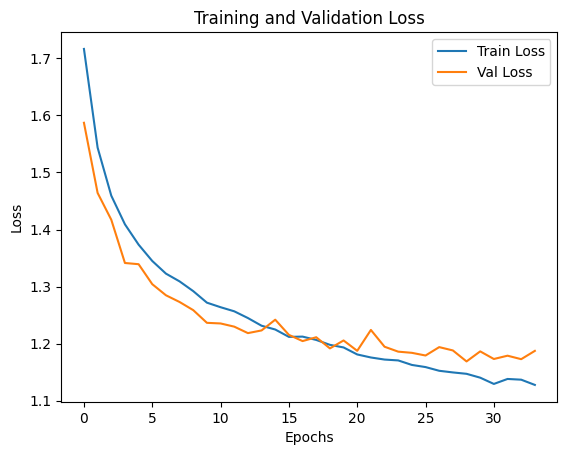

In [8]:
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60)


In [10]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Test the model
test(model, test_loader)

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [12]:
torch.save(model.state_dict(), 'Face_Emotion_Recognition_2.pth')